# Домашнее задание "Сегментация и детекция объектов"

## Задание
### Распознавание рукописного ввода на примере базы MNIST

- Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

- Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

- В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

- Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше $0.6$. Метрика оценивается на тестовой выборке в рамках контеста [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/overview) на Kaggle.

- Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

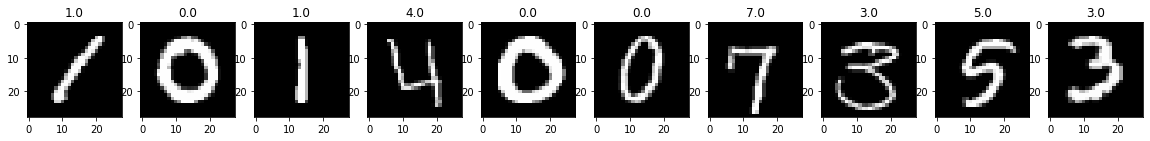

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

### PCA анализ главных компонентов

In [6]:
# меняем размерность из 2мерного в 1мерный - вытягиваем - указываем нужное
X_train = train_img.reshape(-1, 28 * 28).astype(np.float32)
X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)

In [7]:
# центрируем данные
X_train_mean = X_train.mean(axis=0)
X_train -= X_train_mean
X_test_mean = X_test.mean(axis=0)
X_test -= X_test_mean

### Стандартизация данных

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [9]:
X_train = scaler.fit_transform(X_train)

In [10]:
X_test = scaler.transform(X_test)

In [11]:
X_union = np.vstack((X_train, X_test))

In [12]:
cov_union = np.dot(X_union.T, X_union) / X_union.shape[0]

In [13]:
# # матрица ковариации признаков
# cov_train = np.dot(X_train.T, X_train) / X_train.shape[0]
# cov_test = np.dot(X_test.T, X_test) / X_test.shape[0]

In [14]:
# cov_train.shape

In [15]:
# cov_test.shape

In [16]:
U_union, S_union, _ = np.linalg.svd(cov_union)

In [17]:
# U_train, S_train, _ = np.linalg.svd(cov_train)
# U_test, S_test, _ = np.linalg.svd(cov_test)
# # U - собсвенные вектора матрицы ковариации
# # S - собственные значения

In [18]:
# U_train.shape

In [19]:
# U_test.shape

In [20]:
# S_train[:10]

In [21]:
# S_test[:10]

#### Собственные числа

In [22]:
# S_cumsum_train = np.cumsum(S_train) / np.sum(S_train)
# plt.plot(S_cumsum_train, 'o')

In [23]:
# S_cumsum_test = np.cumsum(S_test) / np.sum(S_test)
# plt.plot(S_cumsum_test, 'o')

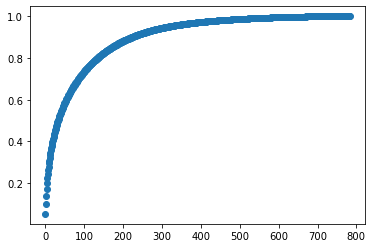

In [24]:
S_cumsum_union = np.cumsum(S_union) / np.sum(S_union)
plt.plot(S_cumsum_union, 'o')

In [25]:
# for i in range(5):
#     print('[%03d] %.3f' % (i, S_cumsum_train[i]))

In [26]:
# for i in range(5):
#     print('[%03d] %.3f' % (i, S_cumsum_test[i]))

In [27]:
for i in range(5):
    print('[%03d] %.3f' % (i, S_cumsum_union[i]))

[000] 0.053
[001] 0.101
[002] 0.139
[003] 0.174
[004] 0.201


## Понижаем размерность

In [28]:
# S_thr_train = 0.9  # задаем порог для накопленной суммы собственных значений

# # определяем необходимое число компонент для заданного порога
# n_comp_train = np.argmax(np.where(S_cumsum_train > S_thr_train, 1, 0))

# print('n_comp_train=%d S=%.3f' % (n_comp_train, S_cumsum_train[n_comp_train]))

In [29]:
# S_thr_test = 0.9  # задаем порог для накопленной суммы собственных значений

# # определяем необходимое число компонент для заданного порога
# n_comp_test = np.argmax(np.where(S_cumsum_test > S_thr_test, 1, 0))

# print('n_comp_test=%d S=%.3f' % (n_comp_test, S_cumsum_test[n_comp_test]))

In [30]:
S_thr_union = 0.9  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp_union = np.argmax(np.where(S_cumsum_union > S_thr_union, 1, 0))

print('n_comp_test=%d S=%.3f' % (n_comp_union, S_cumsum_union[n_comp_union]))

n_comp_test=223 S=0.900


In [31]:
# получаем сжатое представление объектов
Xrot_reduced_train = np.dot(X_train, U_union[:, :n_comp_union])
Xrot_reduced_test = np.dot(X_test, U_union[:, :n_comp_union])

## Разделим выборку на тренировочную и валидационную

In [32]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, Xrot_reduced_train, test_size=0.2,
    random_state=42)

## Модель классификации SVM

In [33]:
# PCA numpy
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train, y_train)
pred_val = clf.predict(x_val)

In [34]:
# проверка кросс валидации cv=5
from sklearn.model_selection import cross_val_score
clf_1 = svm.SVC()
scores = cross_val_score(clf_1, Xrot_reduced_train, train_label, cv=5)
scores

array([0.95869048, 0.96511905, 0.96142857, 0.96333333, 0.96321429])

## Оцениваем качество решение на валидационной выборке

In [35]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9613095238095238


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       816
         1.0       0.98      0.98      0.98       909
         2.0       0.92      0.97      0.94       846
         3.0       0.95      0.95      0.95       937
         4.0       0.97      0.96      0.97       839
         5.0       0.96      0.95      0.95       702
         6.0       0.96      0.97      0.97       785
         7.0       0.96      0.96      0.96       893
         8.0       0.96      0.95      0.96       835
         9.0       0.96      0.94      0.95       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [37]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[803   0   3   0   1   1   7   0   1   0]
 [  0 891   9   1   1   1   2   1   2   1]
 [  1   4 821   4   4   0   4   2   6   0]
 [  1   3  11 890   0   9   1   6  11   5]
 [  1   0   8   0 808   1   5   4   0  12]
 [  2   1   6  12   2 666  10   1   2   0]
 [  4   1  10   0   0   5 763   0   2   0]
 [  0   3  11   4   6   1   0 854   1  13]
 [  1   4   9   9   5   7   3   3 793   1]
 [  2   1   4  12   6   3   0  19   5 786]]


## Визуализация валидационной выборки

In [38]:
pred_train = clf.predict(Xrot_reduced_train)

In [39]:
Xrot_restored_train = np.dot(Xrot_reduced_train, U_union[:,:n_comp_union].T)

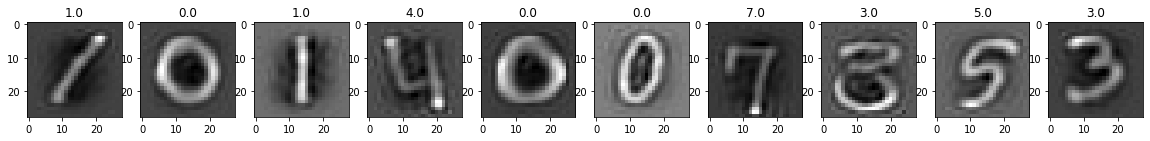

In [40]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored_train[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.title('%s' % pred_train[i-1])
    plt.imshow(img.reshape((28, 28)), cmap='gray');

## Предсказания на тестовых данных

In [41]:
pred_test = clf.predict(Xrot_reduced_test)

In [42]:
Xrot_restored = np.dot(Xrot_reduced_test, U_union[:,:n_comp_union].T)

In [43]:
Xrot_restored.shape

(28000, 784)

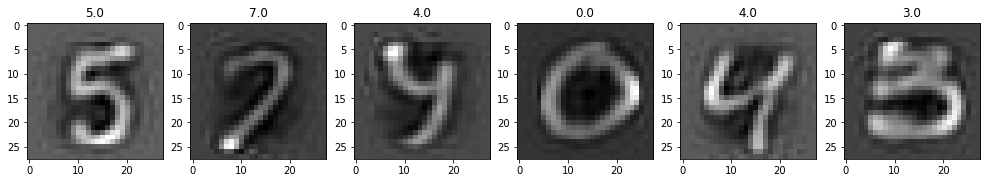

In [44]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[10:16], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.title('%s' % pred_test[i-1 +10])
    plt.imshow(img.reshape((28, 28)), cmap='gray');

## Готовим файл для отправки

In [52]:
with open('submission.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate((pred_test.astype(int)), 1):
        dst.write('%s,%s\n' % (i, p))

In [46]:
!head submission.csv

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [47]:
# Your submission scored 0.41700